The Metropolis-Adjusted Langevin Algorithm (MALA) is a method for sampling from a distribution using discrete-time Langevin dynamics. The key is that for finite dt, occasional rejections become necessary. This notebook shows how the MALA algorithm works in the world's simplest case (Gaussian)

In [1]:
import torch
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline


# Define log prob and grad log prob for a standard normal
def log_prob(x):
    return -1/2*torch.sum(x*x)


def grad_log_prob(x):
    return -x

Run uncorrected dynamics and see that they are slightly incorrect

In [2]:
def run_uncorrected(n_samples, dt):
    x = torch.randn(2)
    x_uncorrected = torch.zeros(n_samples, 2)
    for i in range(n_samples):
        x = x + dt * grad_log_prob(x) + sqrt(2*dt)*torch.randn(2)
        x_uncorrected[i, :] = x
    return x_uncorrected

In [3]:
dt_vals = [.1, .2, .3]
samples = 5000
runs = 20
means = torch.zeros(len(dt_vals), runs)
stds = torch.zeros(len(dt_vals), runs)
for i, dt in enumerate(dt_vals):
    for j in range(runs):
        x = run_uncorrected(samples, dt)
        means[i, j] = x[:,0].mean()
        stds[i, j] = x[:,0].std()

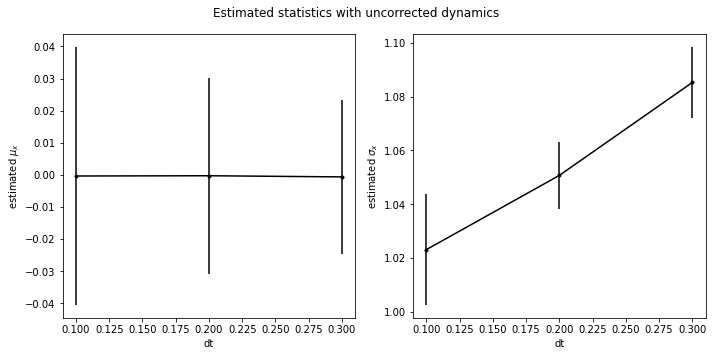

In [4]:
def sem_plot(xaxis, vals, ax):
    mu = vals.mean(dim=1)
    sem = vals.std(dim=1) / sqrt(vals.size(1))
    ax.errorbar(xaxis, mu, yerr=sem*3, marker='.', color='k')

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sem_plot(dt_vals, means, ax[0])
ax[0].set_xlabel('dt')
ax[0].set_ylabel(r'estimated $\mu_x$')
sem_plot(dt_vals, stds, ax[1])
ax[1].set_xlabel('dt')
ax[1].set_ylabel(r'estimated $\sigma_x$')
fig.suptitle('Estimated statistics with uncorrected dynamics')
fig.tight_layout()

Now run with MALA correction

In [5]:
def run_mala(n_samples, dt):
    x = torch.randn(2)
    x_samples = torch.zeros(n_samples, 2)
    u = torch.rand(n_samples).log()
    for i in range(n_samples):
        new_x = x + dt * grad_log_prob(x) + sqrt(2*dt)*torch.randn(2)
        log_q_forward = -1 / (4*dt) * torch.sum((new_x - (x + dt*grad_log_prob(x)))**2)
        log_q_reverse = -1 / (4*dt) * torch.sum((x - (new_x + dt*grad_log_prob(new_x)))**2)
        log_metropolis_ratio =  log_prob(new_x) - log_prob(x) + log_q_reverse - log_q_forward
        if log_metropolis_ratio > u[i]:
            x = new_x
        x_samples[i, :] = x
    return x_samples

In [6]:
mala_means = torch.zeros(len(dt_vals), runs)
mala_stds = torch.zeros(len(dt_vals), runs)
for i, dt in enumerate(dt_vals):
    for j in range(runs):
        mala_x = run_mala(samples, dt)
        mala_means[i, j] = mala_x[:,0].mean()
        mala_stds[i, j] = mala_x[:,0].std()

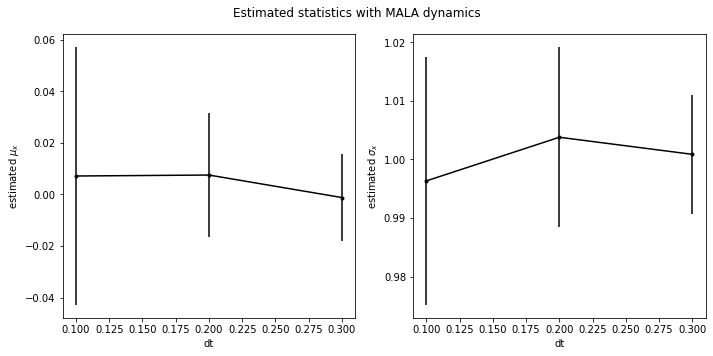

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sem_plot(dt_vals, mala_means, ax[0])
ax[0].set_xlabel('dt')
ax[0].set_ylabel(r'estimated $\mu_x$')
sem_plot(dt_vals, mala_stds, ax[1])
ax[1].set_xlabel('dt')
ax[1].set_ylabel(r'estimated $\sigma_x$')
fig.suptitle('Estimated statistics with MALA dynamics')
fig.tight_layout()